# Chapter 4: Training Models

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# generate some random linear data
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

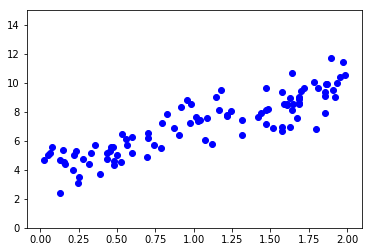

In [20]:
plt.scatter(X,y, c='b')
plt.ylim(0,15)
plt.show();

In [23]:
# comput parameter estimates using the normal equation.
X_b = np.c_[np.ones((100,1)), X] # adds in bias to X
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [24]:
theta_best

array([[ 3.78388797],
       [ 3.14939586]])

In [25]:
# you can make predictions using the theta_best
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[  3.78388797],
       [ 10.08267968]])

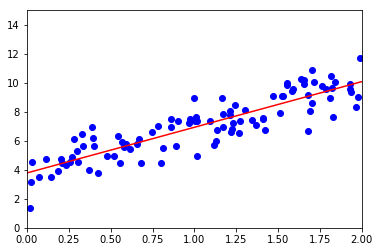

In [32]:
plt.plot(X_new, y_predict, 'r-')
plt.scatter(X, y, c="b")
plt.axis([0,2,0,15])
plt.show();

In [33]:
# repeat using scikit-learn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 3.78388797]), array([[ 3.14939586]]))

In [34]:
lin_reg.predict(X_new)

array([[  3.78388797],
       [ 10.08267968]])

## Batch Gradient Descent

Quick implementation of BGD.

In [35]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization of a parameter vector

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [36]:
theta

array([[ 3.78388797],
       [ 3.14939586]])

How should you choose eta?  Use GridSearch and a tolerance value.

## Stochastic Gradient Descent

This is at the opposite end, where you only use a single (random) training example at a time.  Because of the variations in the data, the solution will bounce around and only on average will converge.  Even when you get close to the minimum it will still bounce around.  The solution will be good but probably not optimal.

Simulated Annealing is the process of gradually decreasing learning rate.

In [50]:
# stochastic gradient descent with simple learning schedule for annealing
n_epochs = 50
t0, t1 = 5, 50 # learning rate hyperparameters
m = 100  # number of samples

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization of model parameters

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m) # generate random index
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [51]:
theta

array([[ 3.76116516],
       [ 3.13360584]])

In [53]:
# repeat using scikit-learn
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=50, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [54]:
sgd_reg.intercept_, sgd_reg.coef_

(array([ 3.80863154]), array([ 3.18266121]))

## Mini-batch Gradient Descent

Middle ground between full data set (Batch) and single sample (Stochastic) examples.  Using Mini-batch, you can leverage GPU parallelization.

In [55]:
# same as Stochastic just use random sample instead of random instance of data

## Polynomial Regression

In [58]:
# create some data
m = 100 # number of samples
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

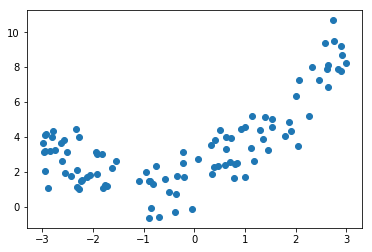

In [59]:
plt.scatter(X,y)
plt.show();

In [61]:
# use scikit-learn's PolynomialFeatures function
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-1.75286526])

In [71]:
X_poly[0]

array([-1.75286526,  3.07253661])

X_poly now contains the original feature + the square of the feature.

In [63]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 1.8753141]), array([[ 0.95517492,  0.50412238]]))

In [93]:
# you can make predictions using the theta_best
X_new = np.linspace(-3,3,100)
X_poly_new = np.array([[-3,9],[3, 9]])
X_poly_new_b = np.c_[np.ones((2,1)), X_poly_new]
#y_predict = lin_reg.predict(X_poly_new)
y_predict = lin_reg.coef_[0][1] * X_new**2 + lin_reg.coef_[0][0] * X_new + lin_reg.intercept_
y_predict[:10]

array([ 3.54689076,  3.42331461,  3.30344183,  3.18727244,  3.07480642,
        2.96604379,  2.86098453,  2.75962865,  2.66197615,  2.56802702])

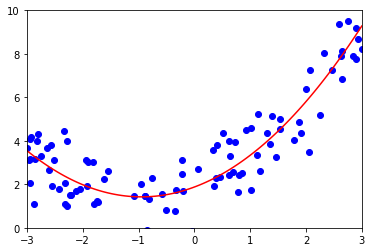

In [94]:
plt.plot(X_new, y_predict, 'r')
plt.scatter(X, y, c="b")
plt.axis([-3,3,0,10])
plt.show();

## Learning Curves

Learning curves are another way to tell if your model is too simple or too complex.

In [102]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.ylim(0,3)
    plt.show();

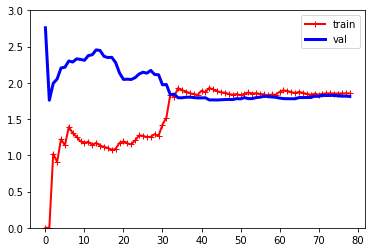

In [103]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

The above figure is an indication of underfitting.  Adding more training data will not help.  Try again using a higher order polynomial.

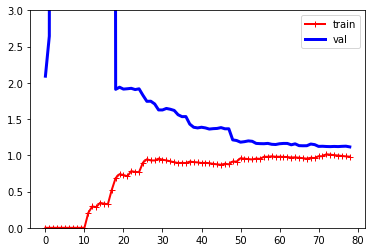

In [104]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

## Regularized Linear Models

For linear models the typically way to regularize is to contrain the weights (coefficients) of the model. Three different methods: Ridge, Lasso, and Elastic Net.

### Ridge Regression

In [105]:
# using scikit-learn
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[ 4.88962263]])

In [107]:
# using stochastic gradient descent
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 3.88585033])

### Lasso Regression

Least Absolute Shrinkage and Selection Operator (LASSO) Regression.  Same as ridge, but uses the 'L1' penalty.  This has the effect of setting some of the model coefficients to exactly zero.  Feature selection!

In [108]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([ 4.41351983])

In [110]:
sgd_reg = SGDRegressor(penalty='l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 3.86173439])

### Elastic Net

Elastic Net is just the middle ground between Ridge and Lasso.  Both penalty terms are included in the cost function and there is a mixing ratio 'r' that controls the amount of one versus the other. 

In [111]:
# example using scikit learn
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([ 4.85053109])

### Early stopping

Keep training until validation reaches a minimum and then stop.

In [119]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# prepare the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler()),
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

# Create model & initialize stuff
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float('inf')
best_epoch = None
best_model = None

# Train
for epoch in range(10000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) # continues where it left off last time
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        
print("Best epoch: {} with a validation error of {}.".format(best_epoch, minimum_val_error))

Best epoch: 198 with a validation error of 0.9628139363963688.


## Logistic Regression

In [122]:
# use the Iris dataset
from sklearn import datasets

iris = datasets.load_iris()
print(list(iris.keys()))
# For now, just try to classify the Virginica type
X = iris['data'][:,3:] # petal width
y = (iris['target'] == 2).astype(np.int) # 1 if Iris-Virginica, else 0

['data', 'target', 'target_names', 'DESCR', 'feature_names']


In [123]:
# train model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

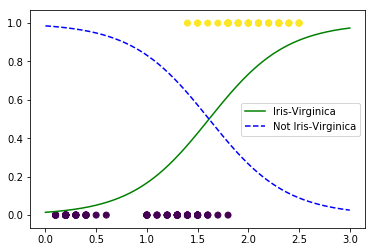

In [137]:
# check out results
X_new = np.linspace(0,3, 1000).reshape(-1,1)
y_prob = log_reg.predict_proba(X_new)
plt.plot(X_new, y_prob[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_prob[:, 0], "b--", label="Not Iris-Virginica")
markers = ['o','x']
plt.scatter(X, y, c=y)
plt.legend()
plt.show();